In [1]:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [2]:
base_dir = "/Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data"

dfs = []
for i in range(1, 43):
    murs_path = os.path.join(base_dir, f"maquette{i}", f"murs{i}.csv")
    if os.path.exists(murs_path):
        with open(murs_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(murs_path, sep=';', header=header_row)
            dfs.append(df)
            print(f"Chargé : {murs_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {murs_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {murs_path}")

if dfs:
    murs_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {murs_concat.shape[0]} lignes, {murs_concat.shape[1]} colonnes")
else:
    murs_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

murs_concat.head()

Chargé : /Users/fabiancordenod/code/fqbq69/BIMpredict-/raw_data/maquette1/murs1.csv (1589 lignes, 146 colonnes)
       Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation 014EC_Mode Constructif  \
0  779920        GO           MUR          INTERIEUR           POUTRE VOILE   
1  780111        GO           MUR          INTERIEUR           POUTRE VOILE   
2  780661        GO           MUR          INTERIEUR                 BANCHE   
3  783007        GO           MUR          INTERIEUR                 BANCHE   
4  783554        GO           MUR          INTERIEUR           POUTRE VOILE   

           Nom           Hauteur Epaisseur                            AI  \
0  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
1  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
2  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
3  Voile BA 20  2,88000000000138       0,2  -0,0000000000013788124467113   
4  Voile BA 20  2,88000000000138 

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,Resistance_feu,Materiau_type,Classification.UniFormat.II.Number,Classification.UniFormat.II.Description,CVC_Lot,VOILE SOUS TOITURE,Classe Beton,STR_As NGF,STR_NIV_ref,Prefixe
0,779920,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,780111,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,780661,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,783007,GO,MUR,INTERIEUR,BANCHE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,783554,GO,MUR,INTERIEUR,POUTRE VOILE,Voile BA 20,"2,88000000000138","0,2","-0,0000000000013788124467113","2,88",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
murs_concat.shape

(39042, 351)

In [4]:
print(murs_concat)

            Id 011EC_Lot 012EC_Ouvrage 013EC_Localisation  \
0       779920        GO           MUR          INTERIEUR   
1       780111        GO           MUR          INTERIEUR   
2       780661        GO           MUR          INTERIEUR   
3       783007        GO           MUR          INTERIEUR   
4       783554        GO           MUR          INTERIEUR   
...        ...       ...           ...                ...   
39037  4538519        GO           MUR          INTERIEUR   
39038  4538520        GO           MUR          INTERIEUR   
39039  4545308        GO           MUR          INTERIEUR   
39040  4556093        GO      LONGRINE            COURANT   
39041  4556253        GO      LONGRINE            COURANT   

      014EC_Mode Constructif          Nom           Hauteur Epaisseur  \
0               POUTRE VOILE  Voile BA 20  2,88000000000138       0,2   
1               POUTRE VOILE  Voile BA 20  2,88000000000138       0,2   
2                     BANCHE  Voile BA 20  2,880

In [5]:
colonnes_a_garder = [
    "011EC_Lot",
    "012EC_Ouvrage",
    "013EC_Localisation",
    "014EC_Mode Constructif",
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel",
    "Famille et type"
]

# On ne garde que les colonnes présentes dans le DataFrame
murs_concat = murs_concat[[col for col in colonnes_a_garder if col in murs_concat.columns]]


In [6]:
print(murs_concat.columns.tolist())

['011EC_Lot', '012EC_Ouvrage', '013EC_Localisation', '014EC_Mode Constructif', 'Epaisseur', 'Sols en intersection', 'Sols coupés (u)', 'Sols coupants (u)', 'Sol au-dessus', 'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués', 'Mur multicouche', 'Profil modifié', 'Extension inférieure', 'Extension supérieure', 'Partie inférieure attachée', 'Partie supérieure attachée', 'Décalage supérieur', 'Décalage inférieur', 'Matériau structurel', 'Famille et type']


In [7]:
murs_concat

,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Epaisseur,Sols en intersection,Sols coupés (u),Sols coupants (u),Sol au-dessus,Sol en-dessous,...,Mur multicouche,Profil modifié,Extension inférieure,Extension supérieure,Partie inférieure attachée,Partie supérieure attachée,Décalage supérieur,Décalage inférieur,Matériau structurel,Famille et type
0,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,3,True,True,...,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
1,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,1,False,True,...,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
2,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,3,True,True,...,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
3,GO,MUR,INTERIEUR,BANCHE,"0,2",0,0,3,True,True,...,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
4,GO,MUR,INTERIEUR,POUTRE VOILE,"0,2",0,0,3,False,True,...,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39037,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,False,False,...,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39038,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,True,False,...,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39039,GO,MUR,INTERIEUR,PREMUR,"0,2",0,0,0,True,False,...,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39040,GO,LONGRINE,COURANT,COFFRE,"0,25",2,0,0,True,False,...,False,False,0,0,0,0,0,"-2,01",BÉTON,Mur de base: Béton 25


In [8]:
import unicodedata
import re

def clean_col(col):
    # Enlever accents
    col = ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn')
    col = col.lower()
    # Remplacer espaces et tirets par _
    col = re.sub(r"[ \-\(\)]", "_", col)
    # Supprimer tout caractère non alphanumérique ou _
    col = re.sub(r"[^a-z0-9_]", "", col)
    # Nettoyer les doubles/triples underscores
    col = re.sub(r"_+", "_", col)
    # Supprimer _ en début/fin
    col = col.strip("_")
    return col

murs_concat.columns = [clean_col(c) for c in murs_concat.columns]
print(murs_concat.columns.tolist())

['011ec_lot', '012ec_ouvrage', '013ec_localisation', '014ec_mode_constructif', 'epaisseur', 'sols_en_intersection', 'sols_coupes_u', 'sols_coupants_u', 'sol_au_dessus', 'sol_en_dessous', 'fenetres', 'portes', 'ouvertures', 'murs_imbriques', 'mur_multicouche', 'profil_modifie', 'extension_inferieure', 'extension_superieure', 'partie_inferieure_attachee', 'partie_superieure_attachee', 'decalage_superieur', 'decalage_inferieur', 'materiau_structurel', 'famille_et_type']


In [9]:
# Définir les targets multi-label (adapte la liste selon tes besoins)
targets = [
    "011ec_lot",
    "012ec_ouvrage",
    "013ec_localisation",
    "014ec_mode_constructif"
]

# Garder seulement les targets présents dans le DataFrame
targets_in_df = [col for col in targets if col in murs_concat.columns]

if not targets_in_df:
    raise ValueError(f"Aucune colonne cible trouvée dans murs_concat. Colonnes disponibles : {murs_concat.columns.tolist()}")

# X et y_multi
X = murs_concat.drop(columns=targets_in_df)
y_multi = murs_concat[targets_in_df]

if X.shape[1] == 0:
    raise ValueError("Aucune variable explicative disponible après suppression des cibles. Vérifiez vos colonnes.")

num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), num_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_features)
    ]
)

# Pipeline complet avec MultiOutputClassifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MultiOutputClassifier(RandomForestClassifier(n_estimators=1000, random_state=42)))
])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Supprimer les lignes avec NaN dans les targets (train et test)
train_notna = y_train.notna().all(axis=1)
test_notna = y_test.notna().all(axis=1)
X_train, y_train = X_train[train_notna], y_train[train_notna]
X_test, y_test = X_test[test_notna], y_test[test_notna]

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction et score baseline
y_pred = pipeline.predict(X_test)
print("Accuracy moyenne multi-label :", (y_pred == y_test.values).mean())

Accuracy moyenne multi-label : 0.9559505409582689


In [10]:
print("Accuracy calculée sur", len(y_test), "échantillons.")

Accuracy calculée sur 7117 échantillons.


In [19]:
X

,epaisseur,sols_en_intersection,sols_coupes_u,sols_coupants_u,sol_au_dessus,sol_en_dessous,fenetres,portes,ouvertures,murs_imbriques,mur_multicouche,profil_modifie,extension_inferieure,extension_superieure,partie_inferieure_attachee,partie_superieure_attachee,decalage_superieur,decalage_inferieur,materiau_structurel,famille_et_type
0,"0,2",0,0,3,True,True,0,0,0,0,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
1,"0,2",0,0,1,False,True,0,0,0,0,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
2,"0,2",0,0,3,True,True,0,1,0,0,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
3,"0,2",0,0,3,True,True,0,1,0,0,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
4,"0,2",0,0,3,False,True,0,0,0,0,False,True,0,0,0,0,0,0,ECSA - Béton Voiles,Mur de base: Voile BA 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39037,"0,2",0,0,0,False,False,0,0,0,0,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39038,"0,2",0,0,0,True,False,0,0,0,0,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39039,"0,2",0,0,0,True,False,0,0,0,0,False,False,0,0,0,0,"0,000000000000382252096642333",0,BÉTON,Mur de base: Béton 20
39040,"0,25",2,0,0,True,False,0,0,0,0,False,False,0,0,0,0,0,"-2,01",BÉTON,Mur de base: Béton 25


In [12]:
y_multi

,011ec_lot,012ec_ouvrage,013ec_localisation,014ec_mode_constructif
0,GO,MUR,INTERIEUR,POUTRE VOILE
1,GO,MUR,INTERIEUR,POUTRE VOILE
2,GO,MUR,INTERIEUR,BANCHE
3,GO,MUR,INTERIEUR,BANCHE
4,GO,MUR,INTERIEUR,POUTRE VOILE
...,...,...,...,...
39037,GO,MUR,INTERIEUR,PREMUR
39038,GO,MUR,INTERIEUR,PREMUR
39039,GO,MUR,INTERIEUR,PREMUR
39040,GO,LONGRINE,COURANT,COFFRE


In [13]:
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_micro_list = []
f1_macro_list = []
for i, col in enumerate(y_test.columns):
	f1_micro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='micro'))
	f1_macro_list.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Moyenne des scores F1 sur toutes les cibles
f1_micro_mean = np.mean(f1_micro_list)
f1_macro_mean = np.mean(f1_macro_list)

print(f"F1 micro (moyenne par cible): {f1_micro_mean:.4f}")
print(f"F1 macro (moyenne par cible): {f1_macro_mean:.4f}")

F1 micro (moyenne par cible): 0.9560
F1 macro (moyenne par cible): 0.8435


In [14]:
import pandas as pd
from sklearn.metrics import f1_score

# Calculer le F1-score pour chaque colonne (target) séparément
f1_per_label = []
for i, col in enumerate(y_test.columns):
    f1_per_label.append(f1_score(y_test.iloc[:, i], y_pred[:, i], average='macro'))

# Récupérer les noms de labels
label_names = list(y_test.columns)

# Construire un DataFrame pour lecture facile
f1_report = pd.DataFrame({
    'Label': label_names,
    'F1-score': f1_per_label
})

# Trier du pire au meilleur
f1_report = f1_report.sort_values(by='F1-score')

# Afficher
print(f1_report)

                    Label  F1-score
2      013ec_localisation  0.767033
3  014ec_mode_constructif  0.781843
1           012ec_ouvrage  0.825082
0               011ec_lot  1.000000


                                                Feature  Importance
13                                       epaisseur_0,05    0.056130
1440                materiau_structurel_<Par catégorie>    0.054073
26                                        epaisseur_0,2    0.049802
1502            famille_et_type_Mur de base: Cloison 10    0.045046
18                                        epaisseur_0,1    0.043512
177                             decalage_superieur_-0,2    0.043246
1550  famille_et_type_Mur de base: EC_PLATRERIE_PPAN_50    0.037095
16                                       epaisseur_0,07    0.023643
1267                               decalage_inferieur_0    0.022782
592                                decalage_superieur_0    0.021744
25                                       epaisseur_0,18    0.020718
3                                              fenetres    0.016457
23                                       epaisseur_0,16    0.016261
1554  famille_et_type_Mur de base: EC_PLATRERIE_

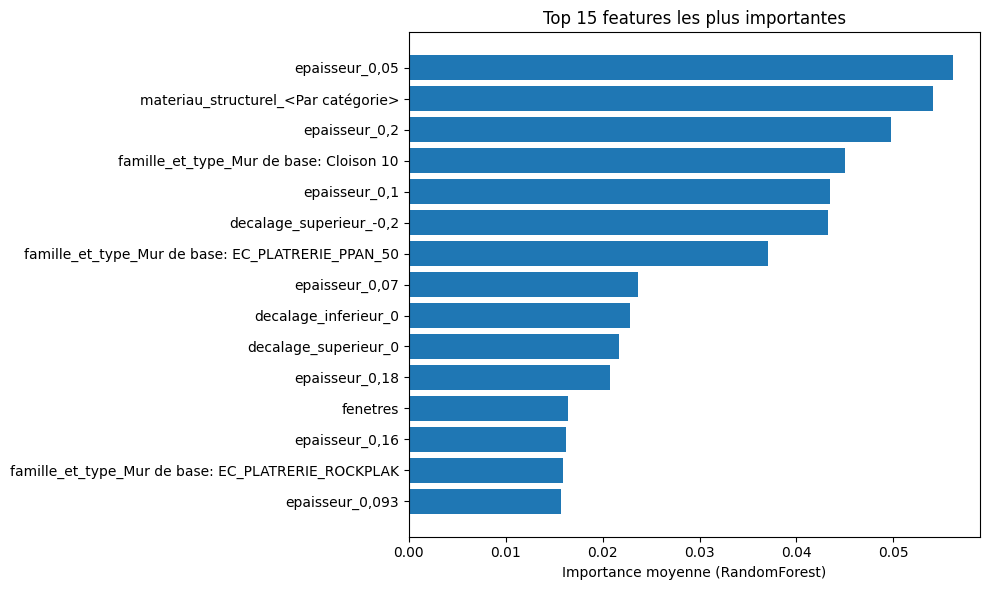

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Afficher les 15 features les plus importantes
print(feat_imp.head(15))

# Visualisation
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:15][::-1], feat_imp['Importance'][:15][::-1])
plt.xlabel("Importance moyenne (RandomForest)")
plt.title("Top 15 features les plus importantes")
plt.tight_layout()
plt.show()

In [16]:
y_pred[:, 0]

array(['GO', 'GO', 'GO', ..., 'PLATRERIE', 'FACADE', 'FACADE'],
      dtype=object)

In [17]:
y_test.iloc[:, 0]

21088           GO
21668           GO
36940           GO
14422           GO
34082    PLATRERIE
           ...    
24890    PLATRERIE
13308       FACADE
3456     PLATRERIE
33601       FACADE
13729       FACADE
Name: 011ec_lot, Length: 7117, dtype: object

In [23]:
y_train["011ec_lot"].value_counts()

GO            22432
PLATRERIE      5261
FACADE          662
COUVERTURE       78
SERRURERIE       15
OUT              13
EXISTANT         11
Name: 011ec_lot, dtype: int64

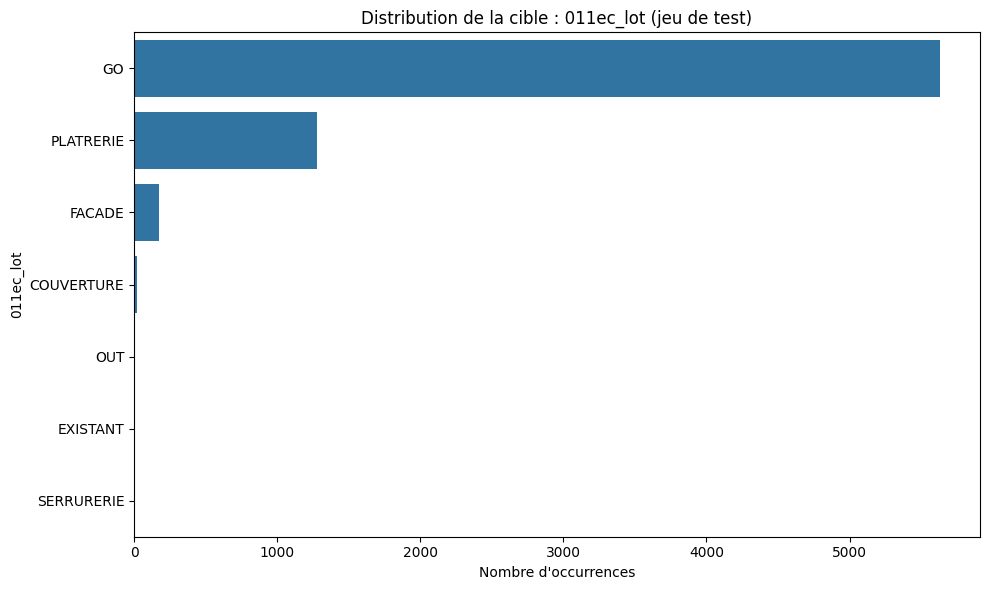

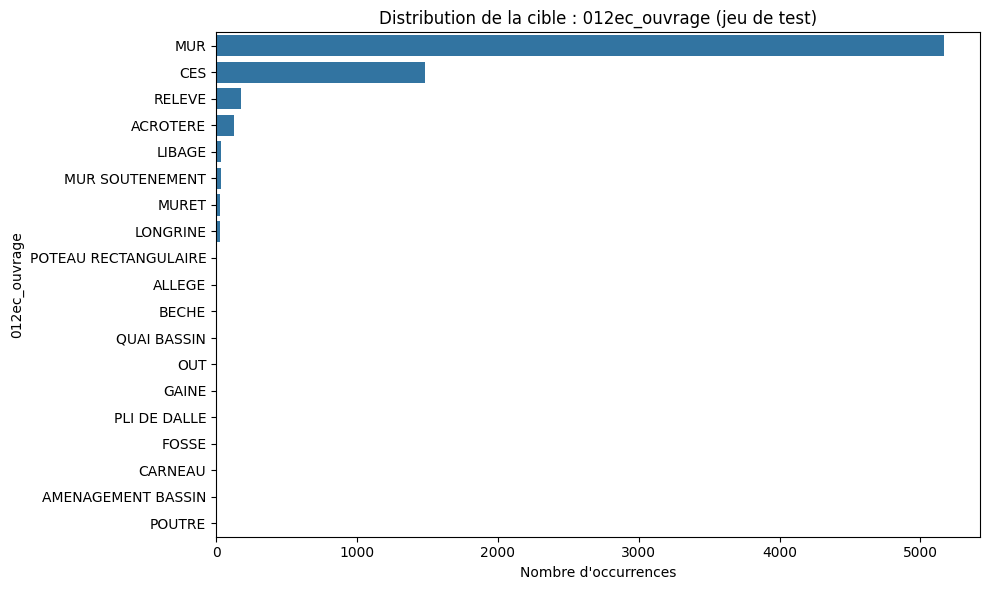

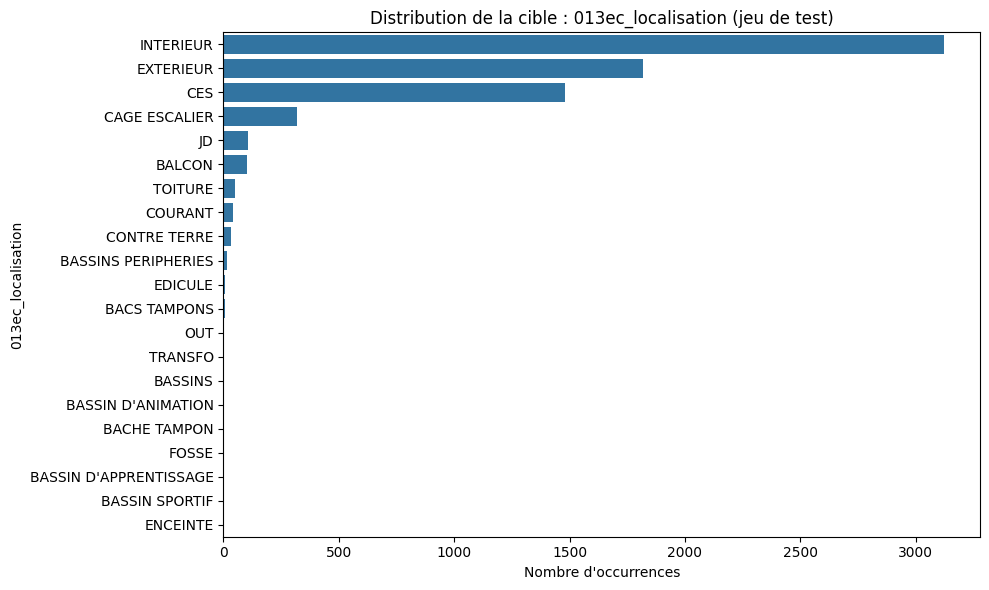

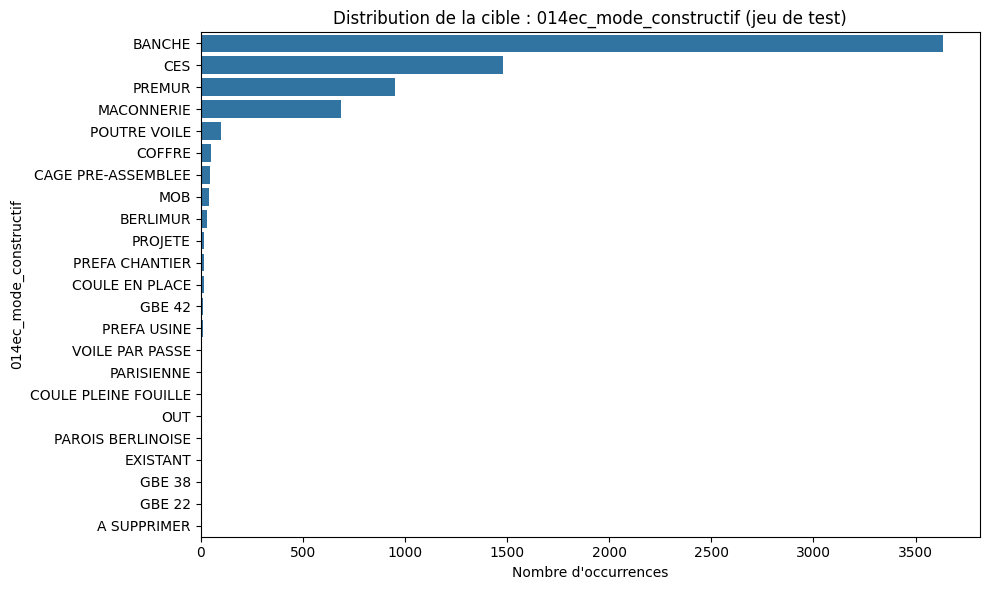

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Récupérer le modèle entraîné
rf_multi = pipeline.named_steps['model']

# Récupérer les noms des features après preprocessing
feature_names = []
if 'preprocessor' in pipeline.named_steps:
    preprocessor = pipeline.named_steps['preprocessor']
    num_features_out = num_features
    # Pour les features catégorielles, récupérer les noms encodés
    cat_features_out = []
    if cat_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
        cat_features_out = encoder.get_feature_names_out(cat_features)
    feature_names = list(num_features_out) + list(cat_features_out)
else:
    feature_names = list(X.columns)

# Calculer l'importance moyenne des features sur toutes les cibles
importances = np.mean([est.feature_importances_ for est in rf_multi.estimators_], axis=0)

# DataFrame pour affichage
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

import seaborn as sns

# Afficher la distribution de chaque cible sur y_test
for col in y_test.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=y_test[col], order=y_test[col].value_counts().index)
    plt.title(f"Distribution de la cible : {col} (jeu de test)")
    plt.xlabel("Nombre d'occurrences")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.metrics import classification_report

# Classification report pour chaque cible séparément
for i, col in enumerate(y_test.columns):
	print(f"=== Classification Report for {col} ===")
	print(classification_report(y_test.iloc[:, i], y_pred[:, i]))

=== Classification Report for 011ec_lot ===
              precision    recall  f1-score   support

  COUVERTURE       1.00      1.00      1.00        21
    EXISTANT       1.00      1.00      1.00         3
      FACADE       1.00      1.00      1.00       175
          GO       1.00      1.00      1.00      5630
         OUT       1.00      1.00      1.00         4
   PLATRERIE       1.00      1.00      1.00      1281
  SERRURERIE       1.00      1.00      1.00         3

    accuracy                           1.00      7117
   macro avg       1.00      1.00      1.00      7117
weighted avg       1.00      1.00      1.00      7117

=== Classification Report for 012ec_ouvrage ===
                      precision    recall  f1-score   support

            ACROTERE       0.97      0.63      0.76       131
              ALLEGE       1.00      0.86      0.92         7
  AMENAGEMENT BASSIN       1.00      1.00      1.00         1
               BECHE       1.00      0.75      0.86         4


/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

                      precision    recall  f1-score   support

         A SUPPRIMER       0.00      0.00      0.00         1
              BANCHE       0.89      0.96      0.92      3634
            BERLIMUR       0.61      0.34      0.44        32
  CAGE PRE-ASSEMBLEE       0.87      0.60      0.71        45
                 CES       1.00      1.00      1.00      1480
              COFFRE       1.00      0.98      0.99        51
      COULE EN PLACE       0.92      0.79      0.85        14
COULE PLEINE FOUILLE       1.00      1.00      1.00         5
            EXISTANT       0.00      0.00      0.00         2
              GBE 22       1.00      1.00      1.00         1
              GBE 38       1.00      1.00      1.00         2
              GBE 42       1.00      1.00      1.00        12
          MACONNERIE       0.99      0.98      0.98       688
                 MOB       1.00      1.00      1.00        39
                 OUT       1.00      1.00      1.00         4
       

/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabiancordenod/.pyenv/versions/3.10.6/envs/BIMpredict2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
